# Solving weighted graph assignment problem with simulated annealing

## Michał Sitko, Krzysztof Jankowski

### 1. Cooling Schemes

#### 1.1 Linear cooling scheme

First we import library and everything what can be usefull:

In [1]:
from graph import *
from simulated_annealing import *
import matplotlib.pyplot as plt

Then we generate graph with 3 vertices in the left part and 5 vertices in the right part. Edge weights should be in range of [0, 10].

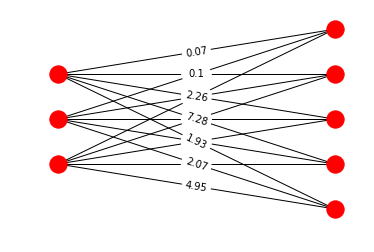

In [2]:
G = Graph.random_bipartite(3, 5, 0, 10)
Graph.draw_bipartite(G)

Tests in this point has following arguments:

In [3]:
parameters = SimulatedAnnealingParameters(
    t_max=100,
    t_min=0,
    k_t=1,
    cooling_scheme=CoolingSchemeLinear(0.00001),
    i_s2_observation_interval=1,
    i_s3_observation_interval=1
)

We create a list for a paramethers and results:

In [6]:
lin = [0.1, 0.2, 0.3, 0.4,  0.5,  0.6,  0.7,  0.8, 0.9]
res1 = []

Now is test fo linear cooling scheme in loop:

In [7]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLinear(lin[i])
    result = SimulatedAnnealing.execute(G, parameters)
    res1.append(result.max_i_s2)
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 2.5 found in 1000 iterations (0.04200911521911621 time).
Best total value 2.5 found in 500 iterations (0.021558761596679688 time).
Best total value 2.5 found in 334 iterations (0.013851165771484375 time).
Best total value 2.5 found in 250 iterations (0.010159969329833984 time).
Best total value 2.5 found in 200 iterations (0.011566877365112305 time).
Best total value 2.5 found in 167 iterations (0.013808012008666992 time).
Best total value 2.5 found in 143 iterations (0.010946989059448242 time).
Best total value 2.5 found in 125 iterations (0.01104116439819336 time).
Best total value 2.5 found in 112 iterations (0.008717775344848633 time).


And show the plot with results depends on paramethers:

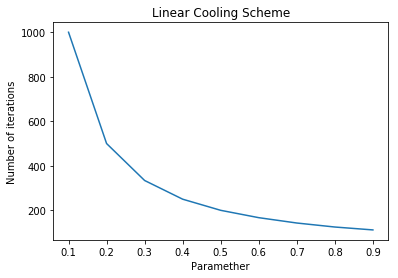

In [8]:
plt.plot(lin,res1)
plt.title("Linear Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Number of iterations")
plt.show()

We observe that this scheme needs less iteration when the paramether is bigger.

#### 1.2 Exponential cooling scheme

All steps are analogous to the previous point. We must only change cooling scheme. Paramethers are the same as earlier

In [9]:
exp = [0.1, 0.2, 0.3, 0.4,  0.5,  0.6,  0.7,  0.8, 0.9]
res2 = []

In [10]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeExponential(exp[i])
    result = SimulatedAnnealing.execute(G, parameters)
    res2.append(result.max_i_s2)
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 2.5 found in 324 iterations (0.017821073532104492 time).
Best total value 2.5 found in 463 iterations (0.01907801628112793 time).
Best total value 2.5 found in 619 iterations (0.024527788162231445 time).
Best total value 2.5 found in 814 iterations (0.03342413902282715 time).
Best total value 2.5 found in 1075 iterations (0.06633806228637695 time).
Best total value 2.5 found in 1459 iterations (0.09525203704833984 time).
Best total value 2.5 found in 2090 iterations (0.10994100570678711 time).
Best total value 2.5 found in 3340 iterations (0.3082761764526367 time).
Best total value 2.5 found in 7073 iterations (0.36491894721984863 time).


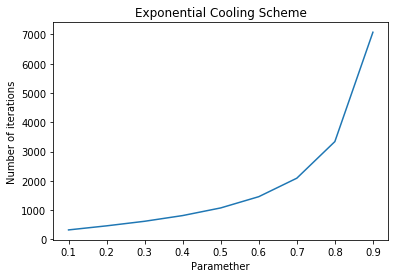

In [11]:
plt.plot(exp,res2)
plt.title("Exponential Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Number of iterations")
plt.show()

This case is the opposite of the previous one, when the paramether is greater, number of iteration is also greater.

#### 1.2 Logarithmic cooling scheme

In this case we change minimal temperature:

In [12]:
parameters.T_min = 0.25

Second parameter is equal to 1, first is variable:

In [13]:
log = [0.2, 0.4, 0.6, 0.8,  1,  1.2,  1.4,  1.6, 1.8]
res3 = []

In [14]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLogarithmic(log[i], 1)
    result = SimulatedAnnealing.execute(G, parameters)
    res3.append(result.max_i_s2)
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 9.34 found in 2 iterations (0.0002620220184326172 time).
Best total value 6.709999999999999 found in 4 iterations (0.00033593177795410156 time).
Best total value 2.5 found in 11 iterations (0.0005550384521484375 time).
Best total value 2.5 found in 24 iterations (0.0011591911315917969 time).
Best total value 2.5 found in 54 iterations (0.0033118724822998047 time).
Best total value 2.5 found in 121 iterations (0.004995822906494141 time).
Best total value 2.5 found in 270 iterations (0.012464046478271484 time).
Best total value 2.5 found in 601 iterations (0.027865886688232422 time).
Best total value 2.5 found in 1339 iterations (0.06615304946899414 time).


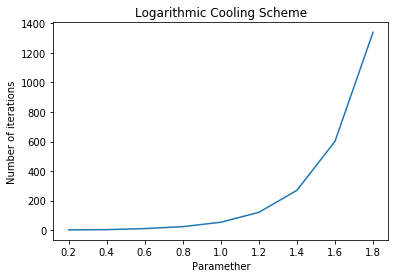

In [15]:
plt.plot(log,res3)
plt.title("Logarithmic Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Number of iterations")
plt.show()

Here we have situation like in previosu case, when the paramether is greater, number of iteration is also greater.

## 2. Various graph configurations

In this part we are testing cooling schemes of the algorithm in 5 points for 5 various graph configuration. We assume following paramethers of cooling schemes: 0.5 for linear, 0.6 for exponential and (1,1) for logharithmic.

Configurations of graphs are following:

In [16]:
G1 = Graph.random_bipartite(3, 5, 0, 10)
G2 = Graph.random_bipartite(10, 20, 0, 10)
G3 = Graph.random_bipartite(40, 80, 0, 10)
G4 = Graph.random_bipartite(120, 200, 0, 10)
G5 = Graph.random_bipartite(255, 255, 0, 10)

Paramethers of algorithm are:

In [17]:
parameters = SimulatedAnnealingParameters(
    t_max=100,
    t_min=0.25,
    k_t=1,
    cooling_scheme=CoolingSchemeLinear(0.5),
    i_s2_observation_interval=1,
    i_s3_observation_interval=1
)

The paramether concerning choosing cooling scheme is variable depends on which scheme we test.

#### 2.1 G1 Graph

Linear cooling scheme:

Best total value 1.79 found in 200 iterations (0.009234189987182617 time).


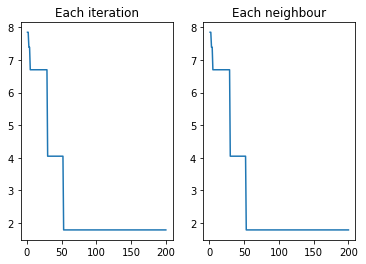

In [19]:
result = SimulatedAnnealing.execute(G1, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Exponential cooling scheme:

Best total value 1.79 found in 12 iterations (0.0006923675537109375 time).


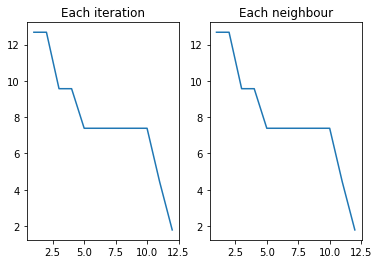

In [20]:
parameters.cooling_scheme = CoolingSchemeExponential(0.6)
result = SimulatedAnnealing.execute(G1, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Logarithmic cooling scheme:

Best total value 1.79 found in 54 iterations (0.0023539066314697266 time).


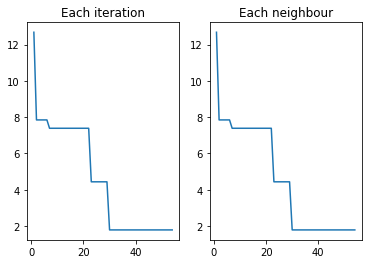

In [21]:
parameters.cooling_scheme = CoolingSchemeLogarithmic(1, 1)
result = SimulatedAnnealing.execute(G1, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

#### 2.2 G2 Graph

First for linear cooling scheme:

Best total value 7.79 found in 200 iterations (0.021695852279663086 time).


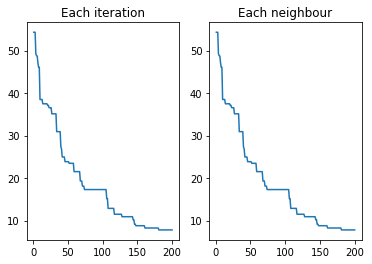

In [22]:
parameters.cooling_scheme = CoolingSchemeLinear(0.5)
result = SimulatedAnnealing.execute(G2, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Exponential cooling scheme:

Best total value 38.599999999999994 found in 12 iterations (0.0020599365234375 time).


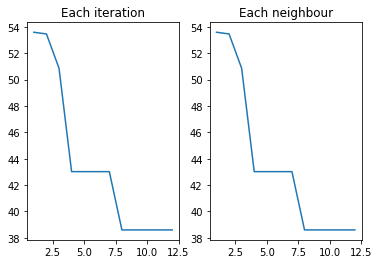

In [23]:
parameters.cooling_scheme = CoolingSchemeExponential(0.6)
result = SimulatedAnnealing.execute(G2, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Logarithmic cooling scheme:

Best total value 17.77 found in 54 iterations (0.00523686408996582 time).


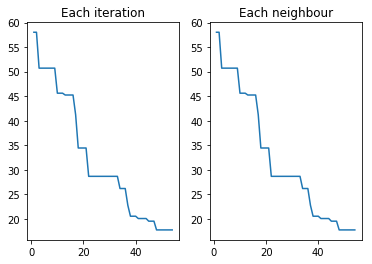

In [24]:
parameters.cooling_scheme = CoolingSchemeLogarithmic(1, 1)
result = SimulatedAnnealing.execute(G2, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

#### 2.3 G3 Graph

Linear cooling scheme:

Best total value 70.46 found in 200 iterations (0.05582475662231445 time).


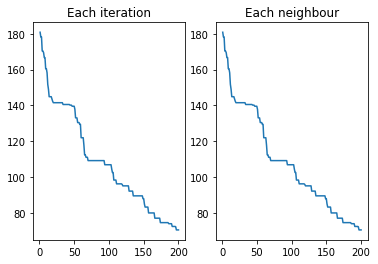

In [25]:
parameters.cooling_scheme = CoolingSchemeLinear(0.5)
result = SimulatedAnnealing.execute(G3, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Exponential cooling scheme:

Best total value 168.57999999999998 found in 12 iterations (0.005303144454956055 time).


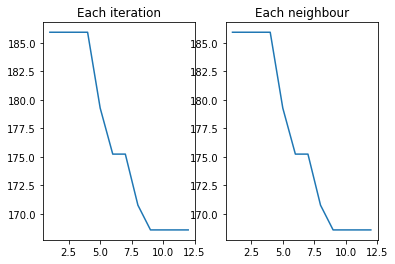

In [26]:
parameters.cooling_scheme = CoolingSchemeExponential(0.6)
result = SimulatedAnnealing.execute(G3, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Logarithmic cooling scheme:

Best total value 128.07999999999998 found in 54 iterations (0.019001007080078125 time).


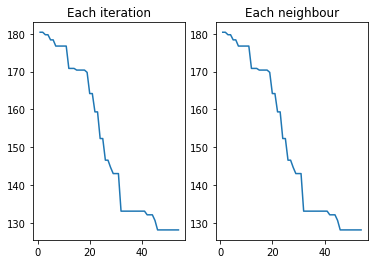

In [27]:
parameters.cooling_scheme = CoolingSchemeLogarithmic(1, 1)
result = SimulatedAnnealing.execute(G3, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

#### 2.4 G4 Graph

Linear cooling scheme:

Best total value 321.65999999999997 found in 200 iterations (0.2173480987548828 time).


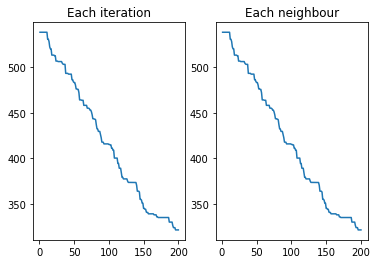

In [28]:
parameters.cooling_scheme = CoolingSchemeLinear(0.5)
result = SimulatedAnnealing.execute(G4, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Exponential cooling scheme:

Best total value 520.9199999999998 found in 12 iterations (0.024651050567626953 time).


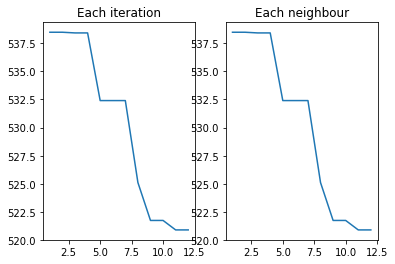

In [29]:
parameters.cooling_scheme = CoolingSchemeExponential(0.6)
result = SimulatedAnnealing.execute(G4, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Logarithmic cooling scheme:

Best total value 436.4099999999999 found in 54 iterations (0.05541396141052246 time).


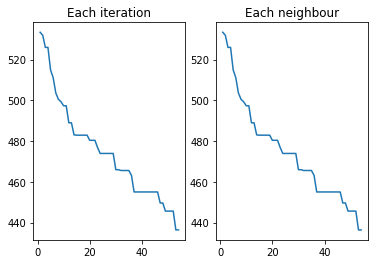

In [30]:
parameters.cooling_scheme = CoolingSchemeLogarithmic(1, 1)
result = SimulatedAnnealing.execute(G4, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

#### 2.5 G5 Graph

Linear cooling scheme:

Best total value 983.2499999999995 found in 200 iterations (0.5995111465454102 time).


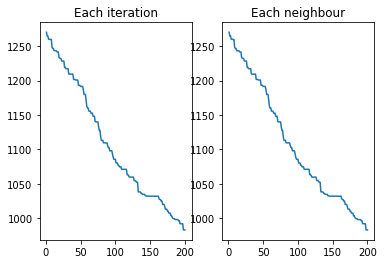

In [31]:
parameters.cooling_scheme = CoolingSchemeLinear(0.5)
result = SimulatedAnnealing.execute(G5, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Exponential cooling scheme:

Best total value 1246.6999999999991 found in 12 iterations (0.08867812156677246 time).


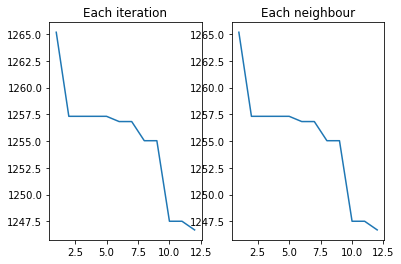

In [32]:
parameters.cooling_scheme = CoolingSchemeExponential(0.6)
result = SimulatedAnnealing.execute(G5, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

Logarithmic cooling scheme:

Best total value 1148.9399999999987 found in 54 iterations (0.20205020904541016 time).


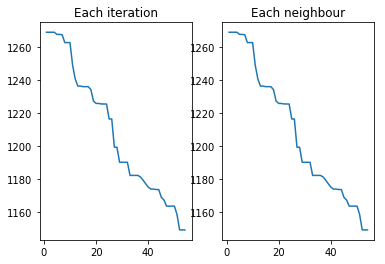

In [33]:
parameters.cooling_scheme = CoolingSchemeLogarithmic(1, 1)
result = SimulatedAnnealing.execute(G5, parameters)
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))
result.draw_observations_plot()

### Conclusions

Except first case, the best solution returns logarithmic scheme. but the shortest time - expotenetial. Only in first expample the best solution was given by linear scheme. This test shown that optimal scheme is linear. Solutions returns by linear scheme are better than exponential, but worst than returns by logarithmic. The same thing concerns the duration of the algorithm. As we see, the larger graphs are, the worse are the found results and longer duration of the algorithm.


##  3. Compiration cooling schemes with various patamethers for various graph configurations

In this part of report we check working the algorithm for every cooling schemes, for 5 graphs and various paramethers. It was split for 5 sections. In each of them we test three schems with different parameters. 


We use graphs from point 2:

In [34]:
G1 = Graph.random_bipartite(3, 5, 0, 10)
G2 = Graph.random_bipartite(10, 20, 0, 10)
G3 = Graph.random_bipartite(40, 80, 0, 10)
G4 = Graph.random_bipartite(120, 200, 0, 10)
G5 = Graph.random_bipartite(255, 255, 0, 10)

Test is carried out with following arguments:

In [35]:
parameters = SimulatedAnnealingParameters(
    t_max=100,
    t_min=1,
    k_t=1,
    cooling_scheme=CoolingSchemeLinear(0.00001),
    i_s2_observation_interval=1,
    i_s3_observation_interval=1
)

The set of paramethers was the same as in point 1: 

In [36]:
lin = [0.1, 0.2, 0.3, 0.4,  0.5,  0.6,  0.7,  0.8, 0.9]
res1 = []

In [37]:
exp = [0.1, 0.2, 0.3, 0.4,  0.5,  0.6,  0.7,  0.8, 0.9]
res2 = []

In [38]:
log = [1.2, 1.4, 1.6, 1.8,  2,  2.2,  2.4,  2.6, 2.8]
res3 = []

#### 3.1 G1 graph

#### 3.1.1 Linear cooling scheme

In [39]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLinear(lin[i])
    result = SimulatedAnnealing.execute(G1, parameters)
    res1.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 5.199999999999999 found in 990 iterations (0.04296278953552246 time).
Best total value 5.199999999999999 found in 495 iterations (0.02263498306274414 time).
Best total value 5.199999999999999 found in 330 iterations (0.013792991638183594 time).
Best total value 5.199999999999999 found in 248 iterations (0.010435104370117188 time).
Best total value 5.199999999999999 found in 198 iterations (0.008193731307983398 time).
Best total value 5.199999999999999 found in 165 iterations (0.0077667236328125 time).
Best total value 5.199999999999999 found in 142 iterations (0.01620769500732422 time).
Best total value 5.199999999999999 found in 124 iterations (0.013015031814575195 time).
Best total value 5.199999999999999 found in 110 iterations (0.014593124389648438 time).


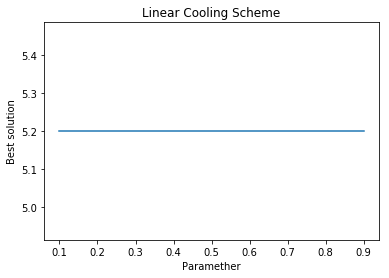

In [40]:
plt.plot(lin,res1)
plt.title("Linear Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.1.2 Exponential cooling scheme

In [41]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeExponential(exp[i])
    result = SimulatedAnnealing.execute(G1, parameters)
    res2.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 10.73 found in 3 iterations (0.0003001689910888672 time).
Best total value 5.199999999999999 found in 3 iterations (0.0002779960632324219 time).
Best total value 10.73 found in 4 iterations (0.0002689361572265625 time).
Best total value 10.73 found in 6 iterations (0.00038504600524902344 time).
Best total value 5.199999999999999 found in 7 iterations (0.0003829002380371094 time).
Best total value 5.199999999999999 found in 10 iterations (0.0009121894836425781 time).
Best total value 5.199999999999999 found in 13 iterations (0.0008101463317871094 time).
Best total value 5.199999999999999 found in 21 iterations (0.0018689632415771484 time).
Best total value 5.199999999999999 found in 44 iterations (0.0020668506622314453 time).


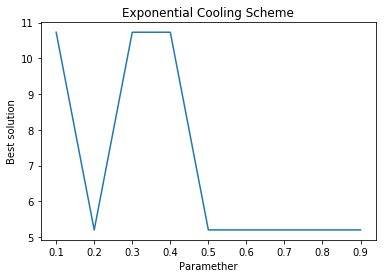

In [42]:
plt.plot(exp,res2)
plt.title("Exponential Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.1.3 Logarithmic cooling scheme

In [43]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLogarithmic(log[i],1)
    result = SimulatedAnnealing.execute(G1, parameters)
    res3.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 10.73 found in 3 iterations (0.0003070831298828125 time).
Best total value 10.73 found in 4 iterations (0.00031304359436035156 time).
Best total value 10.73 found in 4 iterations (0.0002741813659667969 time).
Best total value 9.709999999999999 found in 6 iterations (0.0003349781036376953 time).
Best total value 5.199999999999999 found in 7 iterations (0.0004279613494873047 time).
Best total value 9.709999999999999 found in 9 iterations (0.0004699230194091797 time).
Best total value 5.199999999999999 found in 11 iterations (0.0005638599395751953 time).
Best total value 10.73 found in 13 iterations (0.00061798095703125 time).
Best total value 5.199999999999999 found in 16 iterations (0.0008261203765869141 time).


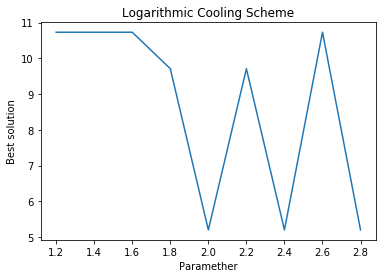

In [44]:
plt.plot(log,res3)
plt.title("Logarithmic Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

### 3.2 G2 graph

#### 3.2.1 Linear cooling scheme

In [45]:
res1 = []

In [46]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLinear(lin[i])
    result = SimulatedAnnealing.execute(G2, parameters)
    res1.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 3.9000000000000004 found in 990 iterations (0.08476018905639648 time).
Best total value 3.79 found in 495 iterations (0.07199525833129883 time).
Best total value 4.050000000000001 found in 330 iterations (0.04242587089538574 time).
Best total value 9.27 found in 248 iterations (0.03512001037597656 time).
Best total value 9.78 found in 198 iterations (0.026591062545776367 time).
Best total value 6.91 found in 165 iterations (0.014349937438964844 time).
Best total value 10.339999999999998 found in 142 iterations (0.012551069259643555 time).
Best total value 9.13 found in 124 iterations (0.010607004165649414 time).
Best total value 10.600000000000001 found in 110 iterations (0.009760856628417969 time).


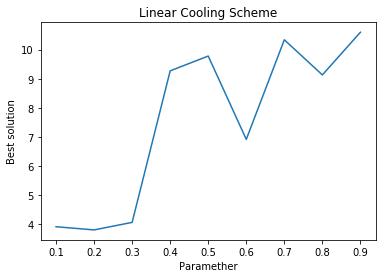

In [47]:
plt.plot(lin,res1)
plt.title("Linear Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.2.2 Exponential cooling scheme

In [48]:
res2 = []

In [49]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeExponential(exp[i])
    result = SimulatedAnnealing.execute(G2, parameters)
    res2.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 33.96 found in 3 iterations (0.0011310577392578125 time).
Best total value 33.96 found in 3 iterations (0.0011820793151855469 time).
Best total value 33.96 found in 4 iterations (0.0014350414276123047 time).
Best total value 33.44 found in 6 iterations (0.002004384994506836 time).
Best total value 29.22 found in 7 iterations (0.001965045928955078 time).
Best total value 33.54 found in 10 iterations (0.0016236305236816406 time).
Best total value 28.470000000000002 found in 13 iterations (0.0030701160430908203 time).
Best total value 29.02 found in 21 iterations (0.0037381649017333984 time).
Best total value 17.73 found in 44 iterations (0.004145145416259766 time).


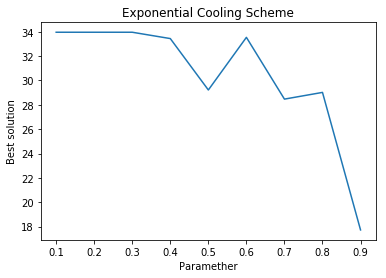

In [50]:
plt.plot(exp,res2)
plt.title("Exponential Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.2.3 Logarithmic cooling scheme

In [51]:
res3 = []

In [52]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLogarithmic(log[i],1)
    result = SimulatedAnnealing.execute(G2, parameters)
    res3.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 33.96 found in 3 iterations (0.0018870830535888672 time).
Best total value 33.96 found in 4 iterations (0.005431175231933594 time).
Best total value 33.96 found in 4 iterations (0.0018770694732666016 time).
Best total value 31.130000000000003 found in 6 iterations (0.0023441314697265625 time).
Best total value 30.190000000000005 found in 7 iterations (0.0020940303802490234 time).
Best total value 26.61 found in 9 iterations (0.002251863479614258 time).
Best total value 32.44 found in 11 iterations (0.0033080577850341797 time).
Best total value 33.96 found in 13 iterations (0.0031349658966064453 time).
Best total value 22.810000000000002 found in 16 iterations (0.0030281543731689453 time).


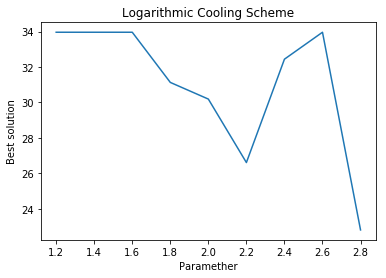

In [53]:
plt.plot(log,res3)
plt.title("Logarithmic Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

### 3.3 G3 graph

#### 3.3.1 Linear cooling scheme

In [54]:
res1 = []

In [55]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLinear(lin[i])
    result = SimulatedAnnealing.execute(G3, parameters)
    res1.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 19.930000000000003 found in 990 iterations (0.533423900604248 time).
Best total value 42.42 found in 495 iterations (0.20063281059265137 time).
Best total value 47.86 found in 330 iterations (0.152055025100708 time).
Best total value 75.57999999999998 found in 248 iterations (0.16080307960510254 time).
Best total value 79.81 found in 198 iterations (0.07916378974914551 time).
Best total value 86.52999999999997 found in 165 iterations (0.10942506790161133 time).
Best total value 94.21999999999997 found in 142 iterations (0.06887292861938477 time).
Best total value 114.69999999999999 found in 124 iterations (0.05313611030578613 time).
Best total value 104.89999999999999 found in 110 iterations (0.07866096496582031 time).


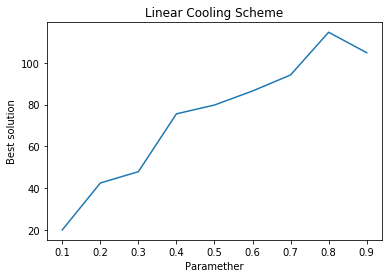

In [56]:
plt.plot(lin,res1)
plt.title("Linear Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.3.2 Exponential cooling scheme

In [57]:
res2 = []

In [58]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeExponential(exp[i])
    result = SimulatedAnnealing.execute(G3, parameters)
    res2.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 209.47000000000006 found in 3 iterations (0.011317014694213867 time).
Best total value 206.57000000000005 found in 3 iterations (0.007462739944458008 time).
Best total value 207.5200000000001 found in 4 iterations (0.009418010711669922 time).
Best total value 208.0100000000001 found in 6 iterations (0.012024164199829102 time).
Best total value 212.72000000000008 found in 7 iterations (0.01205897331237793 time).
Best total value 198.86000000000004 found in 10 iterations (0.009261846542358398 time).
Best total value 182.18000000000004 found in 13 iterations (0.020910978317260742 time).
Best total value 190.41000000000008 found in 21 iterations (0.01790785789489746 time).
Best total value 166.87 found in 44 iterations (0.03032827377319336 time).


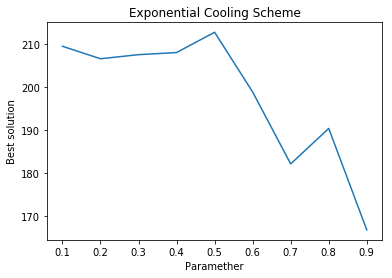

In [59]:
plt.plot(exp,res2)
plt.title("Exponential Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.3.3 Logarithmic cooling scheme

In [60]:
res3 = []

In [61]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLogarithmic(log[i],1)
    result = SimulatedAnnealing.execute(G3, parameters)
    res3.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 212.67000000000007 found in 3 iterations (0.009406089782714844 time).
Best total value 214.01000000000008 found in 4 iterations (0.013267993927001953 time).
Best total value 209.18000000000006 found in 4 iterations (0.012726068496704102 time).
Best total value 208.36000000000007 found in 6 iterations (0.00900888442993164 time).
Best total value 204.36000000000007 found in 7 iterations (0.0072209835052490234 time).
Best total value 185.21000000000004 found in 9 iterations (0.027634382247924805 time).
Best total value 183.27000000000004 found in 11 iterations (0.0176393985748291 time).
Best total value 180.98000000000005 found in 13 iterations (0.00699925422668457 time).
Best total value 169.96000000000004 found in 16 iterations (0.021718978881835938 time).


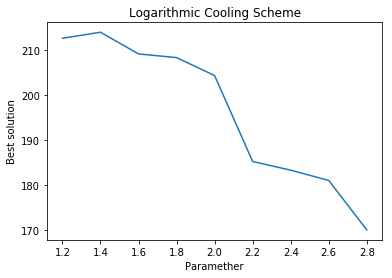

In [62]:
plt.plot(log,res3)
plt.title("Logarithmic Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

### 3.4 G4 graph

#### 3.4.1 Linear cooling scheme

In [63]:
res1 = []

In [64]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLinear(lin[i])
    result = SimulatedAnnealing.execute(G4, parameters)
    res1.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 158.23000000000002 found in 990 iterations (1.1467499732971191 time).
Best total value 227.32000000000002 found in 495 iterations (0.554070234298706 time).
Best total value 290.99000000000007 found in 330 iterations (0.41125988960266113 time).
Best total value 341.6099999999999 found in 248 iterations (0.2866780757904053 time).
Best total value 318.16999999999996 found in 198 iterations (0.25261783599853516 time).
Best total value 371.54 found in 165 iterations (0.17017412185668945 time).
Best total value 403.39 found in 142 iterations (0.2097618579864502 time).
Best total value 421.5699999999999 found in 124 iterations (0.11844921112060547 time).
Best total value 423.77 found in 110 iterations (0.1817610263824463 time).


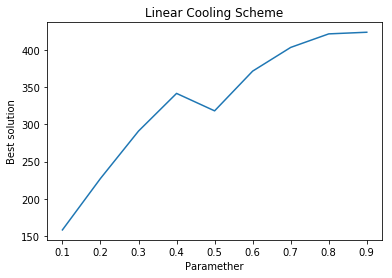

In [65]:
plt.plot(lin,res1)
plt.title("Linear Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.4.2 Exponential cooling scheme

In [66]:
res2 = []

In [67]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeExponential(exp[i])
    result = SimulatedAnnealing.execute(G4, parameters)
    res2.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 620.0200000000001 found in 3 iterations (0.040496110916137695 time).
Best total value 609.0600000000001 found in 3 iterations (0.03498435020446777 time).
Best total value 620.8700000000001 found in 4 iterations (0.06039905548095703 time).
Best total value 614.4200000000002 found in 6 iterations (0.030390024185180664 time).
Best total value 605.59 found in 7 iterations (0.023380041122436523 time).
Best total value 593.0600000000002 found in 10 iterations (0.022794008255004883 time).
Best total value 609.0400000000001 found in 13 iterations (0.026388168334960938 time).
Best total value 571.9300000000001 found in 21 iterations (0.031091928482055664 time).
Best total value 561.88 found in 44 iterations (0.046401023864746094 time).


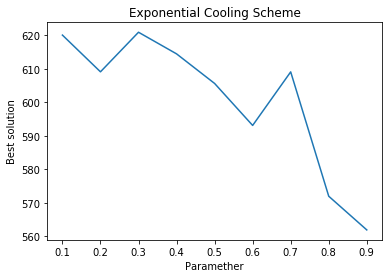

In [68]:
plt.plot(exp,res2)
plt.title("Exponential Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.4.3 Logarithmic cooling scheme

In [69]:
res3 = []

In [70]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLogarithmic(log[i],1)
    result = SimulatedAnnealing.execute(G4, parameters)
    res3.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 618.1000000000001 found in 3 iterations (0.016599655151367188 time).
Best total value 603.38 found in 4 iterations (0.0181121826171875 time).
Best total value 620.73 found in 4 iterations (0.018304824829101562 time).
Best total value 599.6800000000001 found in 6 iterations (0.02642989158630371 time).
Best total value 613.01 found in 7 iterations (0.01884317398071289 time).
Best total value 607.6600000000001 found in 9 iterations (0.021061182022094727 time).
Best total value 583.0 found in 11 iterations (0.022282123565673828 time).
Best total value 590.9900000000001 found in 13 iterations (0.024265050888061523 time).
Best total value 587.9600000000002 found in 16 iterations (0.026355743408203125 time).


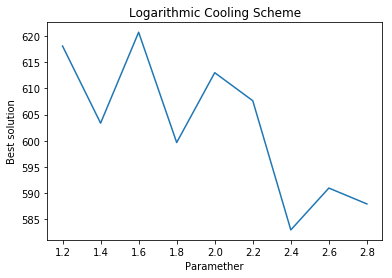

In [71]:
plt.plot(log,res3)
plt.title("Logarithmic Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

### 3.5 G5 graph

#### 3.5.1 Linear cooling scheme

In [72]:
res1 = []

In [73]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLinear(lin[i])
    result = SimulatedAnnealing.execute(G5, parameters)
    res1.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 544.02 found in 990 iterations (1.6766810417175293 time).
Best total value 682.6800000000003 found in 495 iterations (0.832359790802002 time).
Best total value 793.4399999999994 found in 330 iterations (0.636279821395874 time).
Best total value 891.4399999999996 found in 248 iterations (0.670698881149292 time).
Best total value 949.7400000000007 found in 198 iterations (0.4985520839691162 time).
Best total value 965.9000000000001 found in 165 iterations (0.43876194953918457 time).
Best total value 1029.3800000000008 found in 142 iterations (0.3924119472503662 time).
Best total value 978.1200000000003 found in 124 iterations (0.3022940158843994 time).
Best total value 1021.7800000000003 found in 110 iterations (0.3354339599609375 time).


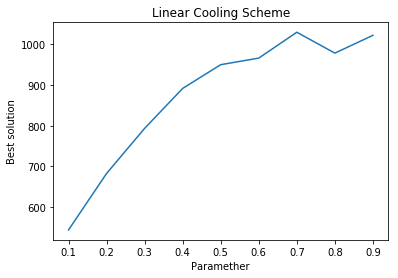

In [74]:
plt.plot(lin,res1)
plt.title("Linear Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.5.2 Exponential cooling scheme

In [75]:
res2 = []

In [76]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeExponential(exp[i])
    result = SimulatedAnnealing.execute(G5, parameters)
    res2.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 1278.9000000000008 found in 3 iterations (0.08678603172302246 time).
Best total value 1272.910000000001 found in 3 iterations (0.062220096588134766 time).
Best total value 1253.2300000000005 found in 4 iterations (0.08235692977905273 time).
Best total value 1268.8100000000009 found in 6 iterations (0.06984210014343262 time).
Best total value 1258.530000000001 found in 7 iterations (0.05285978317260742 time).
Best total value 1259.2900000000006 found in 10 iterations (0.10647702217102051 time).
Best total value 1239.3800000000003 found in 13 iterations (0.09425115585327148 time).
Best total value 1256.0800000000004 found in 21 iterations (0.08299994468688965 time).
Best total value 1186.1800000000003 found in 44 iterations (0.11872196197509766 time).


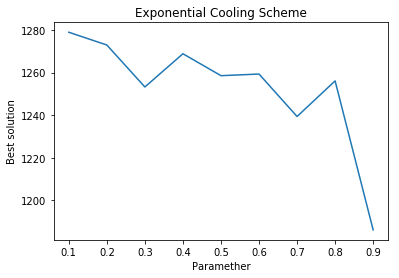

In [77]:
plt.plot(exp,res2)
plt.title("Exponential Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

#### 3.5.3 Logarithmic cooling scheme

In [78]:
res3 = []

In [79]:
for i in range(0,9):
    parameters.cooling_scheme = CoolingSchemeLogarithmic(log[i],1)
    result = SimulatedAnnealing.execute(G5, parameters)
    res3.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 1278.5800000000006 found in 3 iterations (0.05123782157897949 time).
Best total value 1272.9700000000005 found in 4 iterations (0.05407905578613281 time).
Best total value 1262.8800000000006 found in 4 iterations (0.07404208183288574 time).
Best total value 1262.5700000000004 found in 6 iterations (0.06722617149353027 time).
Best total value 1272.6400000000006 found in 7 iterations (0.05790376663208008 time).
Best total value 1258.6300000000006 found in 9 iterations (0.08735489845275879 time).
Best total value 1256.5800000000004 found in 11 iterations (0.09144282341003418 time).
Best total value 1227.7600000000004 found in 13 iterations (0.12920689582824707 time).
Best total value 1201.8200000000004 found in 16 iterations (0.11283206939697266 time).


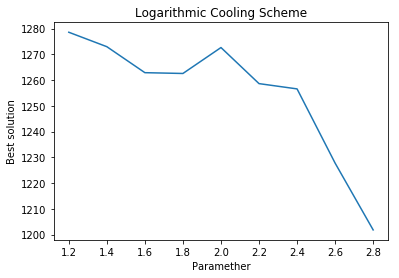

In [80]:
plt.plot(log,res3)
plt.title("Logarithmic Cooling Scheme")
plt.xlabel("Paramether")
plt.ylabel("Best solution")
plt.show()

## 4. Max temperatures

In this point we test various values of maximum cooling temperature. Tests are carried out for 5 graphs cofiguration (like in previous point) and for three cooling schemes with the same paramethers as in point 2. 

In [81]:
G1 = Graph.random_bipartite(3, 5, 0, 10)
G2 = Graph.random_bipartite(10, 20, 0, 10)
G3 = Graph.random_bipartite(40, 80, 0, 10)
G4 = Graph.random_bipartite(120, 200, 0, 10)
G5 = Graph.random_bipartite(255, 255, 0, 10)

In [82]:
parameters = SimulatedAnnealingParameters(
    t_max=100,
    t_min=1,
    k_t=1,
    cooling_scheme=CoolingSchemeLinear(0.5),
    i_s2_observation_interval=1,
    i_s3_observation_interval=1
)

The set of maximum tepmperatures is:

In [83]:
temp = [10, 50, 100, 200,  500,  1000,  2000,  5000, 10000]

### 4.1 G1 graph

#### 4.1.1 Lin

In [84]:
res1 = []
for i in range(0,9):
    parameters.T_max = i
    result = SimulatedAnnealing.execute(G1, parameters)
    res1.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))


Best total value 14.76 found in 0 iterations (0.00042319297790527344 time).
Best total value 14.76 found in 0 iterations (0.00033211708068847656 time).
Best total value 8.69 found in 2 iterations (0.0005130767822265625 time).
Best total value 5.199999999999999 found in 4 iterations (0.0005321502685546875 time).
Best total value 5.199999999999999 found in 6 iterations (0.0013141632080078125 time).
Best total value 8.69 found in 8 iterations (0.0011260509490966797 time).
Best total value 5.199999999999999 found in 10 iterations (0.0012216567993164062 time).
Best total value 4.1899999999999995 found in 12 iterations (0.0014140605926513672 time).
Best total value 5.199999999999999 found in 14 iterations (0.0024042129516601562 time).


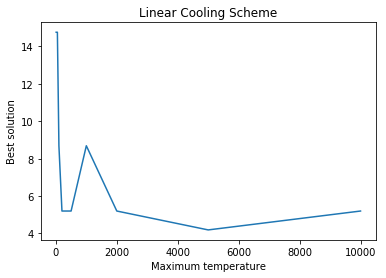

In [85]:
plt.plot(temp,res1)
plt.title("Linear Cooling Scheme")
plt.xlabel("Maximum temperature")
plt.ylabel("Best solution")
plt.show()

#### 4.1.2 Exp

In [86]:
res2 = []
parameters.cooling_scheme = CoolingSchemeExponential(0.6)
for i in range(0,9):
    parameters.T_max = i
    result = SimulatedAnnealing.execute(G1, parameters)
    res2.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 14.76 found in 0 iterations (0.00014519691467285156 time).
Best total value 14.76 found in 0 iterations (0.00011992454528808594 time).
Best total value 14.76 found in 2 iterations (0.0002129077911376953 time).
Best total value 8.69 found in 3 iterations (0.0002238750457763672 time).
Best total value 5.199999999999999 found in 3 iterations (0.00022101402282714844 time).
Best total value 5.199999999999999 found in 4 iterations (0.0005671977996826172 time).
Best total value 5.199999999999999 found in 4 iterations (0.0006639957427978516 time).
Best total value 5.199999999999999 found in 4 iterations (0.0005109310150146484 time).
Best total value 11.27 found in 5 iterations (0.0003421306610107422 time).


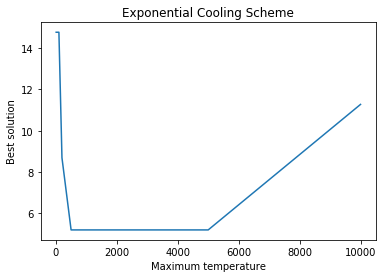

In [87]:
plt.plot(temp,res2)
plt.title("Exponential Cooling Scheme")
plt.xlabel("Maximum temperature")
plt.ylabel("Best solution")
plt.show()

#### 4.1.3 Log

In [88]:
res3 = []
parameters.cooling_scheme = CoolingSchemeLogarithmic(1,1)
for i in range(0,9):
    parameters.T_max = i
    result = SimulatedAnnealing.execute(G1, parameters)
    res3.append(result.solution.get_estimate())
    print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 14.76 found in 0 iterations (0.00013899803161621094 time).
Best total value 14.76 found in 0 iterations (0.00010991096496582031 time).
Best total value 8.28 found in 2 iterations (0.00022411346435546875 time).
Best total value 5.199999999999999 found in 2 iterations (0.0001850128173828125 time).
Best total value 8.69 found in 2 iterations (0.00017905235290527344 time).
Best total value 5.199999999999999 found in 2 iterations (0.0002598762512207031 time).
Best total value 5.199999999999999 found in 2 iterations (0.00038814544677734375 time).
Best total value 14.76 found in 2 iterations (0.00021886825561523438 time).
Best total value 5.199999999999999 found in 2 iterations (0.00039696693420410156 time).


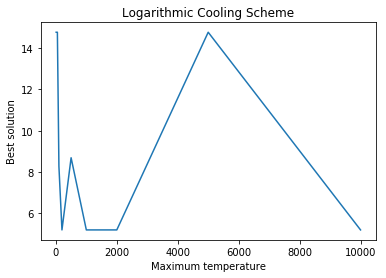

In [90]:
plt.plot(temp,res3)
plt.title("Logarithmic Cooling Scheme")
plt.xlabel("Maximum temperature")
plt.ylabel("Best solution")
plt.show()

### Escorts  - 'natural' dataset scenario #1

In [2]:
import urllib.request
import tarfile
import os

# download dataset tar archive
urllib.request.urlretrieve("http://konect.uni-koblenz.de/downloads/tsv/escorts.tar.bz2", "./data/escorts.tar.bz2")

# extract archive
tar = tarfile.open('./data/escorts.tar.bz2', 'r:bz2')
tar.extractall('./data')
tar.close()

# remove archive
os.remove('./data/escorts.tar.bz2')

The dataset needs to be preprocessed before analysis. Since the first column consist of unique id-s and the second one also (but both are of in different spaces) we shall make them unique. We do so by prefixing the left side with b_ (like buyer) and the right side with e_ (like escort). We also inverse the edge value (change negative opinions (-1) with positive (1) - so that now minimization applied by the algorithm will result in finding the most satisfactionary assignment - for buyers). The last column (timestamp) can be discarded.

In [12]:
import csv

i = 0
i_limit = 100000000 # no_limit

with open('./data/escorts/out.escorts.prep', 'w+') as out_file:
    with open('./data/escorts/out.escorts', 'r') as in_file:
        reader = csv.reader(in_file, delimiter=' ')
        for row in reader:
            if row[0] == '%':
                continue
            
            if i >= i_limit:
                break
            
            out_file.write('b_%s e_%s %s\n' % (row[0], row[1], -int(row[2])))
            i += 1

Now let's load a preprocessed graph into the memory and invoke implemented algorithm.

In [1]:
import networkx as nx
from simulated_annealing import *

nx_escorts = nx.read_edgelist('./data/escorts/out.escorts.prep', comments='%', delimiter=' ', data=(('weight', int),))

In [2]:
from networkx.algorithms import bipartite

print('It is indeed a bipartite graph.' if bipartite.is_bipartite(nx_escorts) else 'It is not a bipartite graph :(')
print('There are %s buyers and escorts in total.' % nx_escorts.number_of_nodes())

buyer_nodes = {n for n, d in nx_escorts.nodes(data=True) if 'b_' in n}
escort_nodes = set(nx_escorts) - buyer_nodes

print('%s of them are buyers and %s are escorts.' % (len(buyer_nodes), len(escort_nodes)))
print('%s no. of \'transactions\' were registered.' % nx_escorts.number_of_edges())

It is indeed a bipartite graph.
There are 5199 buyers and escorts in total.
3389 of them are buyers and 1810 are escorts.
8344 no. of 'transactions' were registered.


In [3]:
# for non_edge in nx.non_edges(nx_escorts):
#     if (non_edge[0] in buyer_nodes and non_edge[1] in escort_nodes) or (non_edge[1] in buyer_nodes and non_edge[0] in escort_nodes):
#         nx_escorts.add_edge(non_edge[0], non_edge[1], weight=0)

parameters = SimulatedAnnealingParameters(
    t_max=100,
    t_min=1,
    k_t=1,
    cooling_scheme=CoolingSchemeLinear(0.001),
    i_s2_observation_interval=1,
    i_s3_observation_interval=1
)

result = SimulatedAnnealing.execute(nx_escorts, parameters)

In [7]:
print("Best total value %s found in %s iterations (%s time)." % (result.solution.get_estimate(), result.max_i_s2, result.total_time))

Best total value 1.6509835945970049e+22 found in 4950 iterations (22.657727003097534 time).


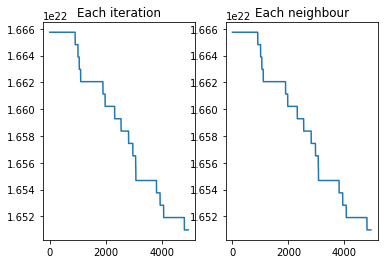

In [8]:
result.solution.get_estimate()
result.draw_observations_plot()
#result.solution.draw()